# Parallelliseren in Python

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

# Ongeparallelliseerde versie

Hieronder wordt tweemaal een willekeurig aantal biertjes gedronken. Vervolgens wordt bij elkaar opgeteld hoeveel biertjes in totaal zijn gedronken. 

Het drinken van een ronde aan biertjes duurt 10 seconden. Het optellen van het totaal aantal gedronken biertjes ook. De totale duur van deze acties is dan ook 30 seconden.

In [2]:
import random
from time import sleep

def drink_round_of_beer() -> int:
    print("Start drinking beer")
    sleep(10)
    number_of_drinks = random.randint(2, 10)
    print("Drank {} beers".format(number_of_drinks))
    return number_of_drinks
    
def get_total_numbers_of_beer_drunk(first_round: int, second_round: int) -> int:
    sleep(10)
    return first_round + second_round

In [3]:
%%time
first_person_round = drink_round_of_beer()
second_person_round = drink_round_of_beer()
total = get_total_numbers_of_beer_drunk(first_person_round, second_person_round)
print(total)

Start drinking beer
Drank 8 beers
Start drinking beer
Drank 8 beers
16
CPU times: user 1.71 s, sys: 384 ms, total: 2.09 s
Wall time: 30 s


# Geparallelliseerde versie

Middels Dask kunnen we acties die niet afhankelijk van elkaar zijn parallel uitvoeren. Dit houdt in dat het drinken van de rondes bier parallel uitgevoerd kan worden. Hierdoor neemt de totale duur van de acties met 10 seconden af naar 20 seconden.

In [4]:
from dask import delayed

In [5]:
%%time
first_person_round = delayed(drink_round_of_beer)()
second_person_round = delayed(drink_round_of_beer)()
total = delayed(get_total_numbers_of_beer_drunk)(first_person_round, second_person_round)
print(total)


Delayed('get_total_numbers_of_beer_drunk-0a1645e1-62ce-4cae-a9c8-1f94ae81673f')
CPU times: user 852 µs, sys: 576 µs, total: 1.43 ms
Wall time: 983 µs


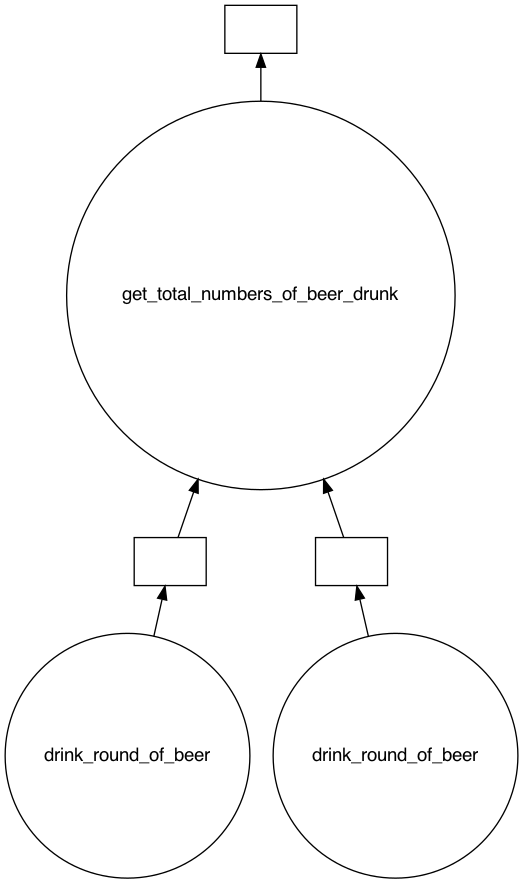

In [6]:
total.visualize()

In [7]:
%%time
total.compute()

CPU times: user 1.11 s, sys: 235 ms, total: 1.35 s
Wall time: 20.2 s


11

# Gebruik van annotaties
Hierboven wordt gebruik gemaakt van de delayed functie, die als wrapper om de aan te roepen functies gebruikt wordt. In plaats hiervan is het ook mogelijk om functies te annoteren met de @delayed annotatie. 

In [8]:
import random
from dask import delayed
from time import sleep

@delayed
def annotated_drink_round_of_beer() -> int:
    print("Start drinking beer")
    sleep(10)
    number_of_drinks = random.randint(2, 10)
    print("Drank {} beers".format(number_of_drinks))
    return number_of_drinks
    
@delayed
def annotated_get_total_numbers_of_beer_drunk(first_round: int, second_round: int) -> int:
    sleep(10)
    return first_round + second_round

In [9]:
%%time
first_person_round = annotated_drink_round_of_beer()
second_person_round = annotated_drink_round_of_beer()
total = annotated_get_total_numbers_of_beer_drunk(first_person_round, second_person_round)
total.compute()

CPU times: user 1.18 s, sys: 251 ms, total: 1.43 s
Wall time: 20 s


8

# Mixen van logica en parallelliseren
Het is niet altijd gewenst om alle functies te delayen. Sommige functies willen we direct evalueren.

In [10]:
from dask import delayed
from time import sleep
from enum import IntEnum

def drink_one_beer() -> int:
    sleep(10)
    return 1
    
def drink_two_beers() -> int:
    sleep(10)
    return 2
    
def get_total_number_of_beers(numbers_of_beers):
    sleep(10)
    return sum(numbers_of_beers)


Weekdays = IntEnum('Weekdays', 'SUN MON TUE WED THU FRI SAT', start=0)

In [11]:
%%time
results = []
for day in Weekdays:
    if (day in (Weekdays.FRI, Weekdays.SAT, Weekdays.SUN)):
        result = drink_two_beers()
    else:
        result = drink_one_beer()
    results.append(result)
    
total = get_total_number_of_beers(results)
print(total)

CPU times: user 4.72 s, sys: 1.04 s, total: 5.75 s
Wall time: 1min 20s


In [12]:
results = []
for day in Weekdays:
    if (day in (Weekdays.FRI, Weekdays.SAT, Weekdays.SUN)):
        result = delayed(drink_two_beers)()
    else:
        result = delayed(drink_one_beer)()
    results.append(result)
    
total = delayed(get_total_number_of_beers)(results)
print(total)

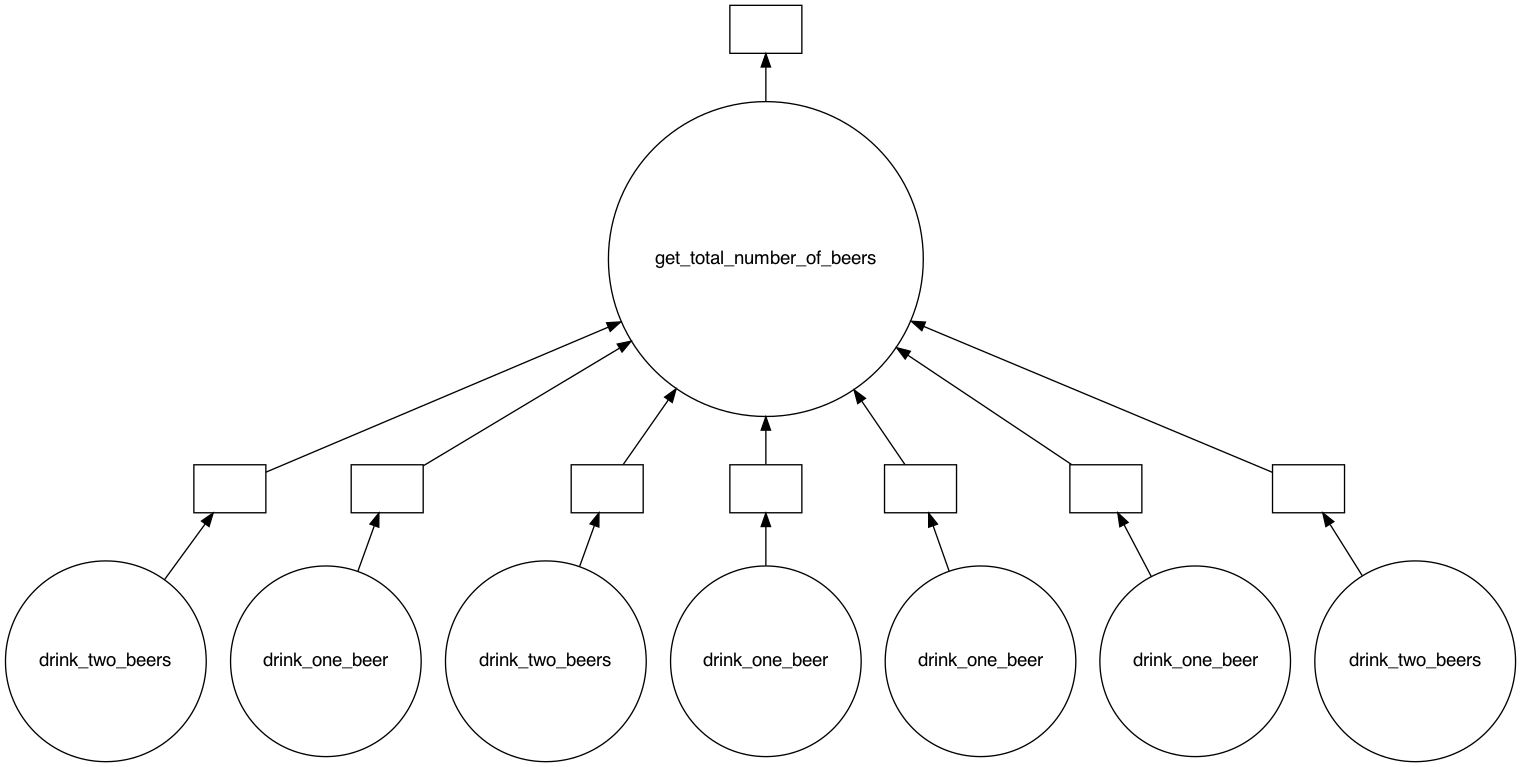

In [13]:
total.visualize()

In [14]:
%%time
total.compute()

CPU times: user 1.28 s, sys: 270 ms, total: 1.55 s
Wall time: 20.1 s


10

In [15]:
client.close()

Start drinking beer
Drank 2 beers
Start drinking beer
Drank 3 beers
Start drinking beer
Drank 6 beers
Start drinking beer
Drank 8 beers
